In [132]:
def get_words(doc):
    words = [s.lower() for s in doc.split()]
    return dict([(w,1) for w in words])

In [133]:
class Classifier:
    def __init__(self):
        self.fc = {} # counts of feature/category combinations
        self.cc = {} # counts of documents in each category
    # Increase the count of a feature/category pair
    def incf(self,f,cat):
        self.fc.setdefault(f,{})
        self.fc[f].setdefault(cat,0)
        self.fc[f][cat]+=1
    # Increase the count of a category
    def incc(self,cat):
        self.cc.setdefault(cat,0)
        self.cc[cat]+=1
    # The number of times a feature has appeared in a category
    def fcount(self,f,cat):
        if f in self.fc and cat in self.fc[f]:
            return float(self.fc[f][cat])
        return 0.0

    def fprob(self, f, cat):
        # If the category count is zero, return 0
        if self.catcount(cat) == 0:
            return 0

        # Otherwise, return the ratio of the feature count to the category count
        return self.fcount(f, cat) / self.catcount(cat)

# The number of items in a category
    def catcount(self,cat):
        if cat in self.cc:
            return float(self.cc[cat])
        return 0
# The total number of items
    def totalcount(self):
        return sum(self.cc.values())
# The list of all categories
    def categories(self):
        return self.cc.keys()

    def train(self, doc, cat): # Extract the features from the document
        features = get_words(doc)
        
        # Increment the count for every feature with the given category
        for f in features:
            self.incf(f, cat)
        
        # Increment the count for this category
        self.incc(cat)
    def weightedprob(self,f,cat,prf,weight=1.0,ap=0.5):
    # Calculate current probability
        basicprob=prf(f,cat)
# Count the number of times this feature has appeared in
# all categories
        totals=sum([self.fcount(f,c) for c in self.categories()])
# Calculate the weighted average
        bp=((weight*ap)+(totals*basicprob))/(weight+totals)
        return bp



In [134]:
cl = Classifier()
cl.train('the quick brown fox jumped over the lazy dog', 'ham')

print(cl.fcount('quick', 'ham' ))
print(cl.fcount('quick', 'spam' ))

1.0
0.0


In [135]:

cl.train('make quick money with us', 'spam')

print(cl.fcount('quick', 'ham' ))
print(cl.fcount('quick', 'spam' ))

1.0
1.0


In [136]:
def fprob(self, f, cat):
    # If the category count is zero, return 0
    if self.catcount(cat) == 0:
        return 0

    # Otherwise, return the ratio of the feature count to the category count
    return self.fcount(f, cat) / self.catcount(cat)


In [137]:
def sampletrain(cl):
    cl.train('Nobody owns the water', 'ham')
    cl.train('the quick rabbit jumps fences', 'ham')
    cl.train('buy pharmaceuticals now', 'spam')
    cl.train('make quick money at the online casino', 'spam')
    cl.train('the quick brown fox jumps', 'ham')

cl = Classifier()
sampletrain(cl)
cl.fprob('quick','ham')

0.6666666666666666

In [138]:
cl.weightedprob('money' , 'bad' , cl.fprob, 1.0, 0.5)


0.25

In [139]:
class NaiveBayes(Classifier):
    def __init__(self):
        Classifier.__init__(self)
        #used the hold the thresholds for each category
        self.thresholds={}
    def docprob(self, item, cat):
        features=get_words(item)
        # Multiply the probabilities of all the features together
        p = 1
        for f in features:
            p*=self.weightedprob(f, cat, self.fprob)
        return p
    def prob(self,item,cat):
        catprob=self.catcount(cat)/self.totalcount()
        docprob=self.docprob(item,cat)
        return docprob*catprob
    def weightedprob(self,f,cat,prf,weight=1.0,ap=0.5):
    # Calculate current probability
        basicprob=prf(f,cat)
# Count the number of times this feature has appeared in
# all categories
        totals=sum([self.fcount(f,c) for c in self.categories()])
# Calculate the weighted average
        bp=((weight*ap)+(totals*basicprob))/(weight+totals)
        return bp
    def setthreshold(self,cat,t):
        self.thresholds[cat]=t
    def getthreshold(self,cat):
        if cat not in self.thresholds: return 1.0
        return self.thresholds[cat]
    def classify(self,item,default=None):
        probs={}
    # Find the category with the highest probability
        max=0.0
        for cat in self.categories():
            probs[cat]=self.prob(item,cat)
        if probs[cat]>max:
            max=probs[cat]
            best=cat
    # Make sure the probability exceeds threshold*next best
        for cat in probs:
            if cat==best: continue
        if probs[cat]*self.getthreshold(best)>probs[best]: return default
        return best

In [140]:
cl = NaiveBayes()
sampletrain(cl)

In [141]:
cl = NaiveBayes()
sampletrain(cl)
cl.classify('quick money', default='unknown')

'spam'

In [142]:
cl.setthreshold('spam', 3.0)
cl.classify('quick money', default='unknown')

'unknown'

In [143]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Load the SMS Spam Collection Dataset
sms_data = pd.read_csv('./spam.csv', encoding='latin-1')
# url: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
# Preprocess the data
sms_data = sms_data[['v1', 'v2']]
sms_data = sms_data.rename(columns={'v1': 'label', 'v2': 'text'})
# Split the data into features and labels
X = sms_data['text']
y = sms_data['label']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [144]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [145]:
# Train a Multinomial Naive Bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [146]:
from sklearn.metrics import accuracy_score, f1_score
y_pred_mnb = mnb.predict(X_test_vec)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
f1_mnb = f1_score(y_test, y_pred_mnb, pos_label='spam')
print(accuracy_mnb)
print(f1_mnb)

0.9820574162679426
0.9282296650717703


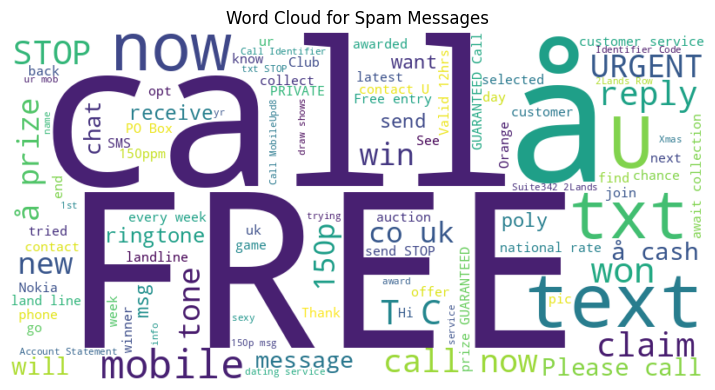

In [147]:
spam_text = ' '.join(sms_data[sms_data['label'] == 'spam']['text'])
from wordcloud import WordCloud
import matplotlib.pyplot as plt
spam_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white',
random_state=42).generate(spam_text)
plt.figure(figsize=(10, 4))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')
plt.tight_layout()
plt.show()